In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from threeML import *
import numpy as np
from threeML.plugins import *
from skylab.datasets import Datasets
import skylab
from skylab.datasets import Datasets
from skylab.ps_llh import PointSourceLLH
from skylab.ps_injector import PointSourceInjector
from skylab.temporal_models import GaussianProfile
from skylab.spectral_models import PowerLaw
from skylab.temporal_scrambling import TimeScrambler
from skylab.temporal_models import TemporalModel
from astropy import units as u
from imp import reload
import scipy.optimize
import mla.core
import mla.injection
import mla.spectral
import warnings
import numpy.lib.recfunctions as rf
warnings.filterwarnings("ignore")
from skylab.ps_llh import PointSourceLLH
from skylab.llh_models import PowerLawLLH,EnergyLLH,ClassicLLH
from skylab.ps_injector import PointSourceInjector
import logging
skylab_logger = logging.getLogger('skylab')
skylab_logger.setLevel(logging.CRITICAL)

import os, sys, glob, abc
sys.path.append("/data/skylab/")
def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

sample, season = 'GFU', 'IC86, 2011-2018'
#sample, season = 'PointSourceTracks', 'IC86, 2012-2017'
d = Datasets[sample]
d.set_repository_path("/data/i3store/users/mjlarson/")
data, mc, livetime = d.season(season, compress=False)
grl = d.grl(season)
sinDec_bins = d.sinDec_bins(season)
energy_bins = d.energy_bins(season)

In [2]:
"""
Setting up the model
"""
ra=np.radians(83.63)
dec=np.radians(45)
inj = PointSourceInjector(gamma = 2., E0 = 1000.)
inj.fill(dec, data, mc, livetime)

testskylab_model=EnergyLLH(twodim_bins=[energy_bins, sinDec_bins])#twodim_bins=100)
#testskylab_model=ClassicLLH()
testskylab=PointSourceLLH.upscale(data,mc,(livetime,100),testskylab_model,seed=1)
testskylab.fit_source(ra,dec)

(1.3063367410490585, {'nsignal': 5.276168264618686, 'gamma': 4.0})

In [3]:
len(sinDec_bins)

42

In [4]:
"""
Inject 30 signal events to test
"""
ni,sample =  inj.sample(src_ra=ra, mean_signal=30, poisson=False)
sample['time']=1
testskylab.pseudo_experiment(inject=sample)
a=testskylab.fit_source(ra,dec)
a

(114.86058941410425, {'nsignal': 28.0976964347611, 'gamma': 2.077268333641381})

In [7]:
"""
Setting up mla, notice it will drop the events with zero singal spatial pdf unless setting fit_position = True
"""
reload(mla.core)
reload(mla)
exp=data
exp=rf.append_fields(exp.copy(),
                           'angErr',
                           exp['sigma'],
                           dtypes=np.float32,usemask = False)
mc=rf.append_fields(mc.copy(),
                           'angErr',
                           mc['sigma'],
                           dtypes=np.float32,usemask = False)



ValueError: field 'angErr' occurs more than once

In [8]:
testmla=mla.core.LLH_point_source(ra ,dec , exp[:5] , mc, "PowerLaw", background = exp , \
                              bkg_2dbins=[sinDec_bins,energy_bins],gamma_points = np.arange(-4, -1, 0.1),background_time_profile = (56224,56324),fit_position=False)


In [9]:
testdata = testskylab._exp
testdata=rf.append_fields(testdata.copy(),
                           'angErr',
                           testdata['sigma'],
                           dtypes=np.float32,usemask = False)
testdata['time'] = 56225 #Since I set a time profile between 56224 to 56324 
testmla.update_data(testdata)
#testmla.update_energy_weight(gamma=-2)

useless=testmla.eval_llh_fit()
#testmla.eval_llh_fit_ns()
testmla.get_fit_result()

ValueError: Found x value not in the domain

In [16]:
testmla.update_energy_weight(gamma=-1.3)

In [17]:
testmla.energy

array([6.09909279e-02, 2.52120393e-01, 2.69155312e-01, ...,
       1.88347694e-01, 3.07433719e-01, 7.89230847e+01])

In [19]:
a=testmla.evaluate_interpolated_ratio()

In [10]:
testmla.gamma_point[-1]

-1.0999999999999974

In [20]:
sob_spline = np.zeros(len(testmla.data), dtype=object)
for i in range(len(testmla.data)):
    spline = scipy.interpolate.UnivariateSpline(testmla.gamma_point,
                                np.log(a[:,i]),
                                k = 2,
                                s = 0,
                                ext = 'raise')
    sob_spline[i] = spline

In [21]:
def inner_ts(parameter):
    gamma = parameter[0]
    ns = parameter[1]
    e_lh_ratio = testmla.get_energy_sob(gamma, sob_spline)
    ts = ( ns/testmla.N * (e_lh_ratio*testmla.spatial*testmla.t_lh_ratio - 1))+1
    return -2*(np.sum(np.log(ts))+testmla.drop*np.log(1-ns/testmla.N))

In [26]:
bounds= [[-4, -1.11],[0,testmla.N]]
bf_params = scipy.optimize.minimize(inner_ts,
                                    x0 = [-2,1],
                                    bounds = bounds,
                                    method = 'SLSQP',
                                    )

In [27]:
bf_params

     fun: -131.2503563041612
     jac: array([-0.00067329, -0.00056839])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([-1.97761476, 27.68446283])

In [15]:
e_lh_ratio = testmla.get_energy_sob(-2, sob_spline)

In [16]:
np.isnan(e_lh_ratio).sum()

1

In [17]:
ts = ( 6/testmla.N * (e_lh_ratio*testmla.spatial*testmla.t_lh_ratio - 1))+1

In [27]:
spline([testmla.data[np.argwhere(np.isnan(ts))]['sinDec'][0][0],testmla.data[np.argwhere(np.isnan(ts))]['logE'][0][0]])

array([-inf])

In [19]:
testmla.data[np.argwhere(np.isnan(ts))]['sinDec'][0][0]

-0.21023535509454672

In [74]:
testmla.data[np.argwhere(np.isnan(ts))]['sinDec'][0][0]

-0.21023535509454672

In [81]:
i = np.searchsorted(testmla.energybins[0],testmla.data[np.argwhere(np.isnan(ts))]['sinDec'][0][0])-1
j = np.searchsorted(testmla.energybins[1],testmla.data[np.argwhere(np.isnan(ts))]['logE'][0][0])-1

In [84]:
np.log(ratio[i][j])

-2.5315043981573964

In [28]:

sim=mc
gamma=-2
bins=testmla.energybins
r'''create the S/B ratio 2d spline for a given gamma.
args:
data: Background data
sim: Monte Carlo Simulation dataset
gamma: spectral index
bins: Bins defination,first one is sinDec binning and the second one is logE binning.

returns:
spline,bins:The S/B energy spline and the binning. 
'''
# background
bins = np.array(bins)
bg_h, xedges, yedges  = np.histogram2d(np.sin(data['dec']),
                                       data['logE'],
                                       bins=bins,
                                       normed=True)
bg_h /= np.sum(bg_h,axis=1)[:,None]                                       

# signal
sig_w = sim['ow'] * sim['trueE']**gamma
sig_w /= np.sum(sig_w)
sig_h, xedges, yedges = np.histogram2d(np.sin(sim['dec']),
                                       sim['logE'],
                                       bins=bins,
                                       normed=True,
                                       weights = sig_w)
sig_h /= np.sum(sig_h,axis=1)[:,None]   
ratio = sig_h / bg_h
for i in range(ratio.shape[0]):
    # Pick out the values we want to use.
    # We explicitly want to avoid NaNs and infinities
    values = ratio[i]
    good = np.isfinite(values) & (values>0)
    mc_values = sig_h[i]
    notmc_domain = np.logical_not(np.isfinite(mc_values) & (mc_values>0))
    notgood = np.logical_not(good)
    x, y = bins[1][:-1][good], values[good]

    # Do a linear interpolation across the energy range
    spline = scipy.interpolate.UnivariateSpline(x, y,
                                                k = 1,
                                                s = 0,
                                                ext = 1)

    # And store the interpolated values
    ratio[i][notgood] = spline(bins[1][:-1][notgood])
    ratio[i][np.logical_not(notmc_domain)&notgood] = np.percentile((ratio[np.isfinite(ratio) & (ratio>1)]),99)

binsmid0 = (bins[0][1:] + bins[0][:-1]) / 2    
binsmid1 = (bins[1][1:] + bins[1][:-1]) / 2    
spline = scipy.interpolate.RegularGridInterpolator(
        (binsmid0,binsmid1), np.log(ratio),
        method="linear",
        bounds_error=True,
        fill_value=0.)


In [22]:
ratio

array([[1.00000000e-05, 1.00000000e-05, 1.00000000e-05, ...,
        1.00000000e-05, 1.00000000e-05, 1.00000000e-05],
       [1.00000000e-05, 1.00000000e-05, 1.00000000e-05, ...,
        1.00000000e-05, 1.00000000e-05, 1.00000000e-05],
       [1.00000000e-05, 1.00000000e-05, 1.00000000e-05, ...,
        1.00000000e-05, 1.00000000e-05, 1.00000000e-05],
       ...,
       [1.35704925e-01, 1.29401416e-02, 2.29640355e-02, ...,
        1.00000000e-05, 1.00000000e-05, 1.00000000e-05],
       [2.68160127e-02, 7.39465018e-03, 1.89524864e-02, ...,
        1.00000000e-05, 1.00000000e-05, 1.00000000e-05],
       [6.19736806e-02, 4.53696910e-02, 5.21772423e-02, ...,
        1.00000000e-05, 1.00000000e-05, 1.00000000e-05]])

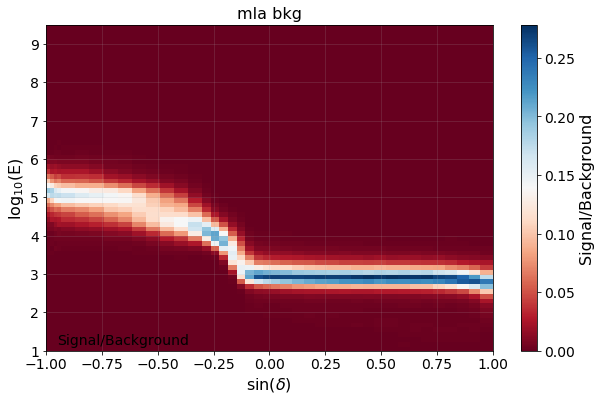

In [15]:
from matplotlib import pyplot as plt, colors
fig, ax = plt.subplots(figsize=(10,6))
binsize=25
sindec=np.linspace(-1,1,binsize)
logE=np.linspace(1,8,binsize)
mlaratio = np.zeros((binsize,binsize))
sinDec_bins = d.sinDec_bins(season)
energy_bins = d.energy_bins(season)
cmesh = ax.pcolormesh(sinDec_bins, energy_bins, bg_h.T,
                     cmap = 'RdBu')
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"mla bkg", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)

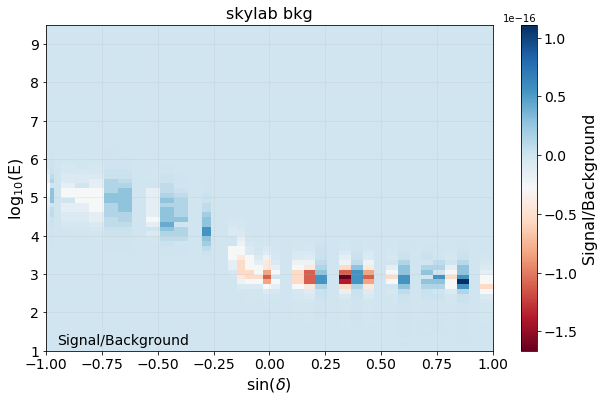

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
binsize=25
sindec=np.linspace(-1,1,binsize)
logE=np.linspace(1,8,binsize)
mlaratio = np.zeros((binsize,binsize))
sinDec_bins = d.sinDec_bins(season)
energy_bins = d.energy_bins(season)
cmesh = ax.pcolormesh(sinDec_bins, energy_bins, testskylab.llh_model._wB_hist - bg_h.T,#testskylab.llh_model._wB_hist,
                     cmap = 'RdBu')
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"skylab bkg", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)

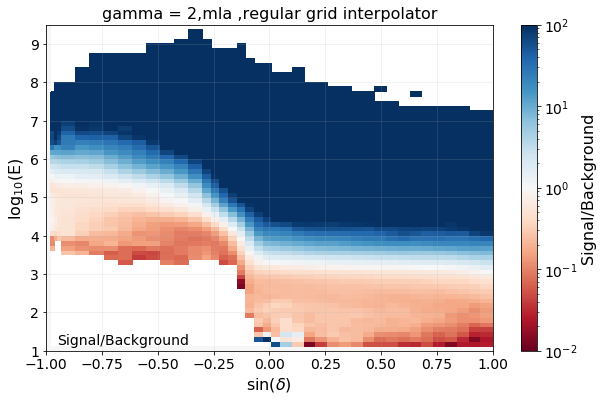

In [29]:
from matplotlib import pyplot as plt, colors
fig, ax = plt.subplots(figsize=(10,6))
binsize=25
sindec=np.linspace(-1,1,binsize)
logE=np.linspace(1,8,binsize)
mlaratio = np.zeros((binsize,binsize))
sinDec_bins = d.sinDec_bins(season)
energy_bins = d.energy_bins(season)
# for i in range(binsize):
#     for j in range(binsize):
#         mlaratio[i][j] = np.exp(testmla.ratio[20]([sindec[i],logE[j]]))
mlaratio = np.zeros((len(sinDec_bins),len(energy_bins)))
for i,sin in enumerate(sinDec_bins):
    for j,energy in enumerate(energy_bins):
        mlaratio[i][j] = np.exp(testmla.ratio[20]([sin,energy]))
cmesh = ax.pcolormesh(sinDec_bins, energy_bins, mlaratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,mla ,regular grid interpolator", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)
#np.save("mla_ratio.npy",mlaratio.T)

In [86]:
mlaratio

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        ,        nan,        nan, ...,        nan,        nan,
        1.        ],
       [1.        ,        nan,        nan, ...,        nan,        nan,
        1.        ],
       ...,
       [1.        , 0.02429191, 0.01428541, ...,        nan,        nan,
        1.        ],
       [1.        , 0.0273257 , 0.0239998 , ...,        nan,        nan,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [11]:
mlaratio.max()

960.2171648907747

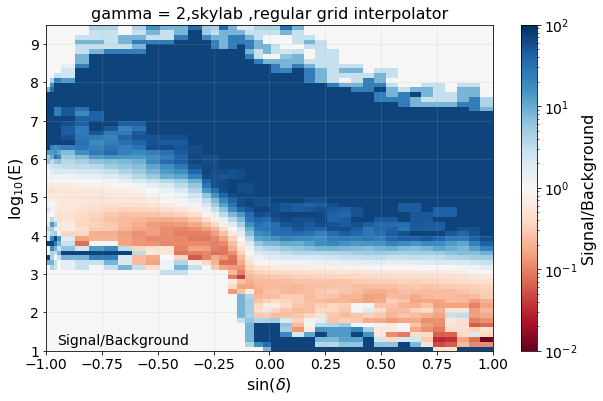

In [10]:
events = testskylab._exp[:len(sinDec_bins)*len(energy_bins)]
n=0

for i,sin in enumerate(sinDec_bins):
    for j,energy in enumerate(energy_bins):
        events[n]['sinDec']=sin
        events[n]['logE']=energy
        n+=1
        

e, _ = testskylab.llh_model.weight(events, gamma=2.0)        # energy s/b with fit gamma. Fixed in Liz's analysis to 2.0
ratio=np.reshape(e,(len(sinDec_bins),len(energy_bins)))
from matplotlib import pyplot as plt, colors
fig, ax = plt.subplots(figsize=(10,6))
sindec=np.linspace(-1,1,binsize)
logE=np.linspace(1,8,binsize)
cmesh = ax.pcolormesh(sinDec_bins, energy_bins, ratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,skylab ,regular grid interpolator", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)


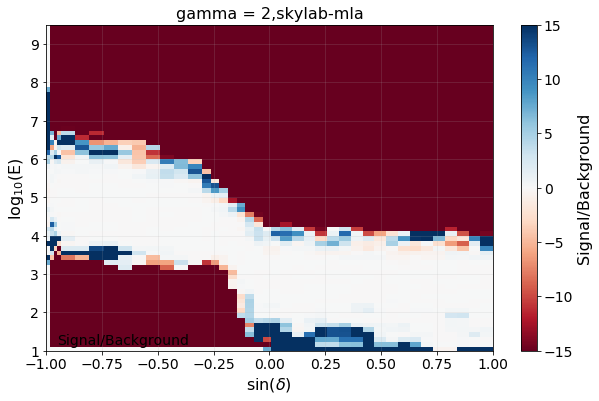

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
cmesh = ax.pcolormesh(sinDec_bins, energy_bins, ratio.T - mlaratio.T,
                     cmap = 'RdBu',
                     vmin = 15,
                     vmax = -15)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,skylab-mla", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [12]:
(ratio.T - mlaratio.T)[:,15]

array([ 0.00000000e+00, -6.23206366e+02, -6.23206366e+02, -6.23206366e+02,
       -6.23206366e+02, -6.23206366e+02, -6.23206366e+02, -6.23206366e+02,
       -6.23206366e+02, -6.23206366e+02, -6.23206366e+02, -6.23206366e+02,
       -6.23206366e+02, -6.23206366e+02, -6.23206366e+02, -6.23206366e+02,
       -6.23206366e+02, -4.90963071e+01, -6.41819093e+00, -8.85353236e-01,
       -1.96563141e-02,  4.43395663e-03,  7.66845041e-03,  1.20866613e-03,
        1.01387607e-03, -2.11757305e-03, -1.10599000e-02,  9.41845153e-03,
        1.95952074e-02,  2.39312367e-01,  2.25527963e-01, -9.92312929e-01,
        8.30700140e-01,  8.62645849e+00,  1.30986335e+01, -1.55938083e+00,
       -3.78660621e+01, -1.12098953e+02, -1.61046675e+02, -2.42188485e+02,
       -3.38447353e+02, -3.57764338e+02, -4.48282744e+02, -5.41328619e+02,
       -5.53215016e+02, -5.53215016e+02, -5.53215016e+02, -4.29379521e+02,
       -4.29379521e+02, -5.53215016e+02, -5.53215016e+02, -5.53215016e+02,
       -5.53215016e+02, -

In [15]:
data = exp
sim = mc
gamma = -2
bins=[np.linspace(-1,1,100),np.linspace(1,8,100)]
r'''create the S/B ratio 2d spline for a given gamma.
args:
data: Background data
sim: Monte Carlo Simulation dataset
gamma: spectral index
bins: Bins defination,first one is sinDec binning and the second one is logE binning.

returns:
spline,bins:The S/B energy spline and the binning. 
'''
# background
bins = np.array(bins)
bg_w = np.ones(len(data), dtype=float)
bg_w /= np.sum(bg_w)
bg_h, xedges, yedges  = np.histogram2d(np.sin(data['dec']),
                                       data['logE'],
                                       bins=bins,
                                       weights = bg_w)

# signal
sig_w = sim['ow'] * sim['trueE']**gamma
sig_w /= np.sum(sig_w)
sig_h, xedges, yedges = np.histogram2d(np.sin(sim['dec']),
                                       sim['logE'],
                                       bins=bins,
                                       weights = sig_w)

ratio = sig_h / bg_h
for i in range(ratio.shape[0]):
    # Pick out the values we want to use.
    # We explicitly want to avoid NaNs and infinities
    values = ratio[i]
    good = np.isfinite(values) & (values>0)
    notgood = np.logical_not(good)
    x, y = bins[1][:-1][good], values[good]

    # Do a linear interpolation across the energy range
    spline = scipy.interpolate.UnivariateSpline(x, y,
                                                k = 1,
                                                s = 0,
                                                ext = 3)

    # And store the interpolated values
    ratio[i][notgood] = spline(bins[1,:-1][notgood])

binsmid0 = (bins[0][1:] + bins[0][:-1]) / 2    
binsmid1 = (bins[1][1:] + bins[1][:-1]) / 2    
spline = scipy.interpolate.RegularGridInterpolator(
        (binsmid0,binsmid1), np.log(ratio),
        method="linear",
        bounds_error=False,
        fill_value=0.)


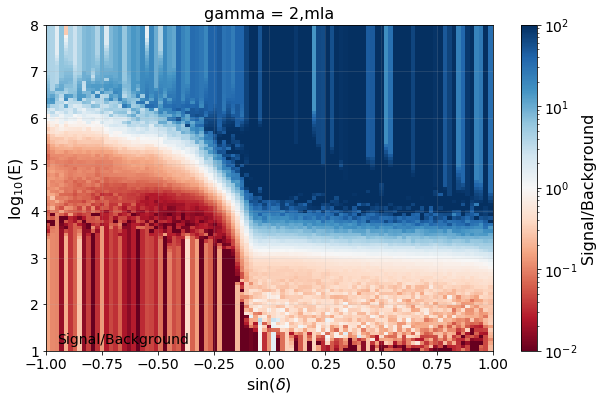

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
cmesh = ax.pcolormesh(np.linspace(-1,1,100), np.linspace(1,8,100), ratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,mla", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)